## Building an LSTM using Keras

Here we will build an LSTM for looking at the Airline time series problem using Keras. The analogous example is built in another notebook in this directory using PyTorch.

To get started, it is easiest to use `conda` to install keras and tensorflow:
```shell
conda install -c conda-forge keras
conda install -c conda-forge tensorflow
```


In [1]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

from keras.models import Sequential
from keras.layers import Dense, LSTM


Using TensorFlow backend.


In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
passengers = pd.read_csv('../examples/MonthlyFlights/AirPassengers.csv')
passengers.set_index('Month', inplace=True)
passengers.head()

pSeries = passengers['#Passengers'].astype('float32')

In [4]:
pSeries

Month
1949-01    112.0
1949-02    118.0
1949-03    132.0
1949-04    129.0
1949-05    121.0
1949-06    135.0
1949-07    148.0
1949-08    148.0
1949-09    136.0
1949-10    119.0
1949-11    104.0
1949-12    118.0
1950-01    115.0
1950-02    126.0
1950-03    141.0
1950-04    135.0
1950-05    125.0
1950-06    149.0
1950-07    170.0
1950-08    170.0
1950-09    158.0
1950-10    133.0
1950-11    114.0
1950-12    140.0
1951-01    145.0
1951-02    150.0
1951-03    178.0
1951-04    163.0
1951-05    172.0
1951-06    178.0
           ...  
1958-07    491.0
1958-08    505.0
1958-09    404.0
1958-10    359.0
1958-11    310.0
1958-12    337.0
1959-01    360.0
1959-02    342.0
1959-03    406.0
1959-04    396.0
1959-05    420.0
1959-06    472.0
1959-07    548.0
1959-08    559.0
1959-09    463.0
1959-10    407.0
1959-11    362.0
1959-12    405.0
1960-01    417.0
1960-02    391.0
1960-03    419.0
1960-04    461.0
1960-05    472.0
1960-06    535.0
1960-07    622.0
1960-08    606.0
1960-09    508.0
1960-10 

Note that Jason Brownlee of Machine Learning Mastery [uses this dataset as an example as well](https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/). He gets **much** better predictions than I do for late times, but that is because he makes an error in his preprocessing.

* In my example, I have split the data and then fit the standard scalar
* JB has fit the scaler (in his case, MinMaxScaler) to the entire dataset, _then_ split into train test.

JB's approach means his features never stray outside of the (0,1) range, so the non-linearities are well under control.

If you change the cell below to
```python
cutoff_index = int(len(pSeries)*0.67)

X_train, X_test = pSeries.iloc[:cutoff_index], pSeries.iloc[cutoff_index:-1]

ssX = StandardScaler()
ssX.fit(pSeries.values)

# note change to just "transform" here
X_train_scaled = ssX.transform(X_train.values.reshape(-1,1))
X_test_scaled = ssX.transform(X_test.values.reshape(-1,1))

target = ssX.transform(pSeries.shift(-1)[:-1].values.reshape(-1,1)) # last value will be in NaN
y_train, y_test = target[:cutoff_index,:], target[cutoff_index:,:]
```
I get similar results to JB

In [5]:
# When doing the train/test split, we want to make sure we are 
# not using future info.

# Note to self: use time series cross validation techniques
cutoff_index = int(len(pSeries)*0.67)

X_train, X_test = pSeries.iloc[:cutoff_index], pSeries.iloc[cutoff_index:-1]

ssX = StandardScaler()

X_train_scaled = ssX.fit_transform(X_train.values.reshape(-1,1))
X_test_scaled = ssX.transform(X_test.values.reshape(-1,1))

target = ssX.transform(pSeries.shift(-1)[:-1].values.reshape(-1,1)) # last value will be in NaN
y_train, y_test = target[:cutoff_index,:], target[cutoff_index:,:]

## Now create the model

Include a picture of model here

In [6]:
look_back = 1

model=Sequential()
# input_shape = (number of timesteps, number of features)
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [7]:
# Expect the data to be of the form:
#  - number of samples
#  - time-steps per sample
#  - number of features
# Here we are treating each sample as containing only one timestep
X_train_scaled = X_train_scaled.reshape(-1, 1, 1)
X_test_scaled = X_test_scaled.reshape(-1,1,1)
history = model.fit(X_train_scaled, y_train, epochs=100, batch_size=1, verbose=1,
                   validation_data=(X_test_scaled, y_test))

Train on 96 samples, validate on 47 samples
Epoch 1/100
96/96 [==============================] - 1s 10ms/step - loss: 0.9475 - val_loss: 8.2868
Epoch 2/100
96/96 [==============================] - 0s 3ms/step - loss: 0.8347 - val_loss: 7.5903
Epoch 3/100
96/96 [==============================] - 0s 3ms/step - loss: 0.7287 - val_loss: 6.9849
Epoch 4/100
96/96 [==============================] - 0s 3ms/step - loss: 0.6295 - val_loss: 6.4135
Epoch 5/100
96/96 [==============================] - 0s 3ms/step - loss: 0.5380 - val_loss: 5.8141
Epoch 6/100
96/96 [==============================] - 0s 2ms/step - loss: 0.4549 - val_loss: 5.1479
Epoch 7/100
96/96 [==============================] - 0s 2ms/step - loss: 0.3777 - val_loss: 4.5584
Epoch 8/100
96/96 [==============================] - 0s 3ms/step - loss: 0.3104 - val_loss: 4.0506
Epoch 9/100
96/96 [==============================] - 0s 3ms/step - loss: 0.2539 - val_loss: 3.5986
Epoch 10/100
96/96 [==============================] - 0s 3ms/ste

96/96 [==============================] - 0s 2ms/step - loss: 0.1053 - val_loss: 1.5742
Epoch 83/100
96/96 [==============================] - 0s 2ms/step - loss: 0.1050 - val_loss: 1.5342
Epoch 84/100
96/96 [==============================] - 0s 2ms/step - loss: 0.1050 - val_loss: 1.5553
Epoch 85/100
96/96 [==============================] - 0s 3ms/step - loss: 0.1050 - val_loss: 1.5445
Epoch 86/100
96/96 [==============================] - 0s 2ms/step - loss: 0.1052 - val_loss: 1.5294
Epoch 87/100
96/96 [==============================] - 0s 3ms/step - loss: 0.1048 - val_loss: 1.5533
Epoch 88/100
96/96 [==============================] - 0s 2ms/step - loss: 0.1050 - val_loss: 1.5503
Epoch 89/100
96/96 [==============================] - 0s 3ms/step - loss: 0.1049 - val_loss: 1.5690
Epoch 90/100
96/96 [==============================] - 0s 3ms/step - loss: 0.1047 - val_loss: 1.5374
Epoch 91/100
96/96 [==============================] - 0s 3ms/step - loss: 0.1052 - val_loss: 1.5414
Epoch 92/100


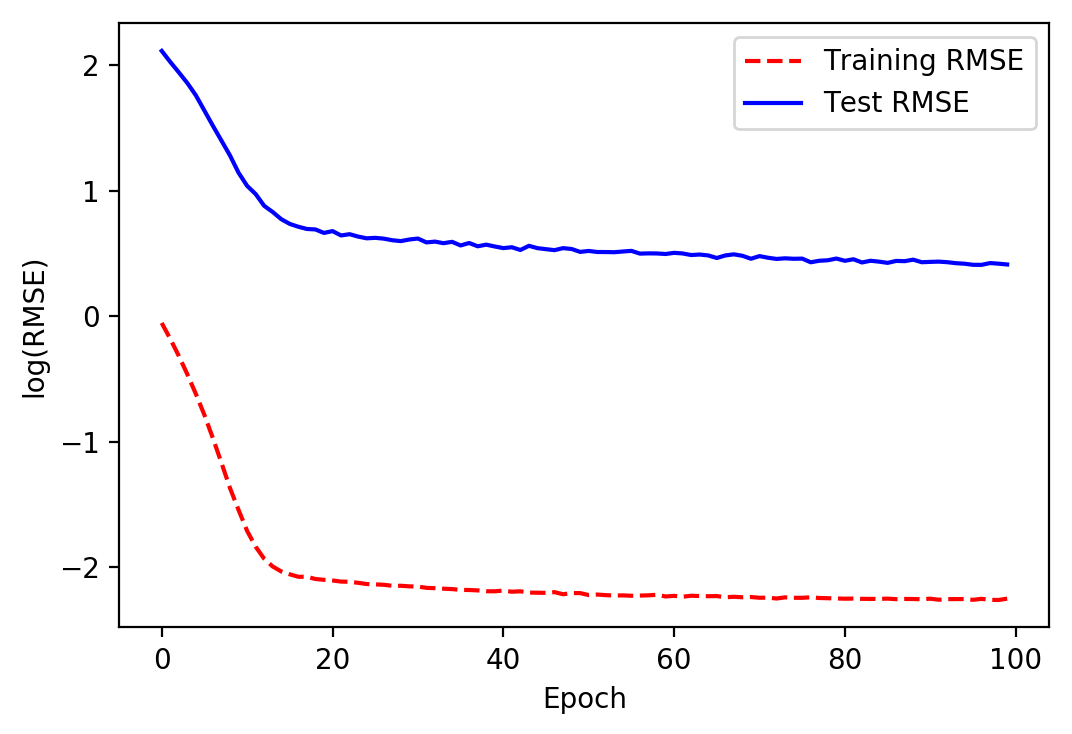

In [8]:
# make a plot of the loss
training_loss = history.history['loss']
test_loss = history.history['val_loss']

epochs = range(len(training_loss))

plt.figure(dpi=200)
plt.plot(epochs, np.log(training_loss), 'r--', label='Training RMSE')
plt.plot(epochs, np.log(test_loss), 'b-', label='Test RMSE')
plt.xlabel('Epoch')
plt.ylabel('log(RMSE)')
plt.legend()

We see **massive** overfitting in this dataset.

Let's plot the actual amounts, and see how bad the problem actually is.

In [9]:
train_predict = ssX.inverse_transform(model.predict(X_train_scaled))
test_predict = ssX.inverse_transform(model.predict(X_test_scaled))

all_features = np.concatenate([X_train_scaled, X_test_scaled])
all_targets  = np.concatenate([y_train, y_test])
all_predict = ssX.inverse_transform(model.predict(all_features))

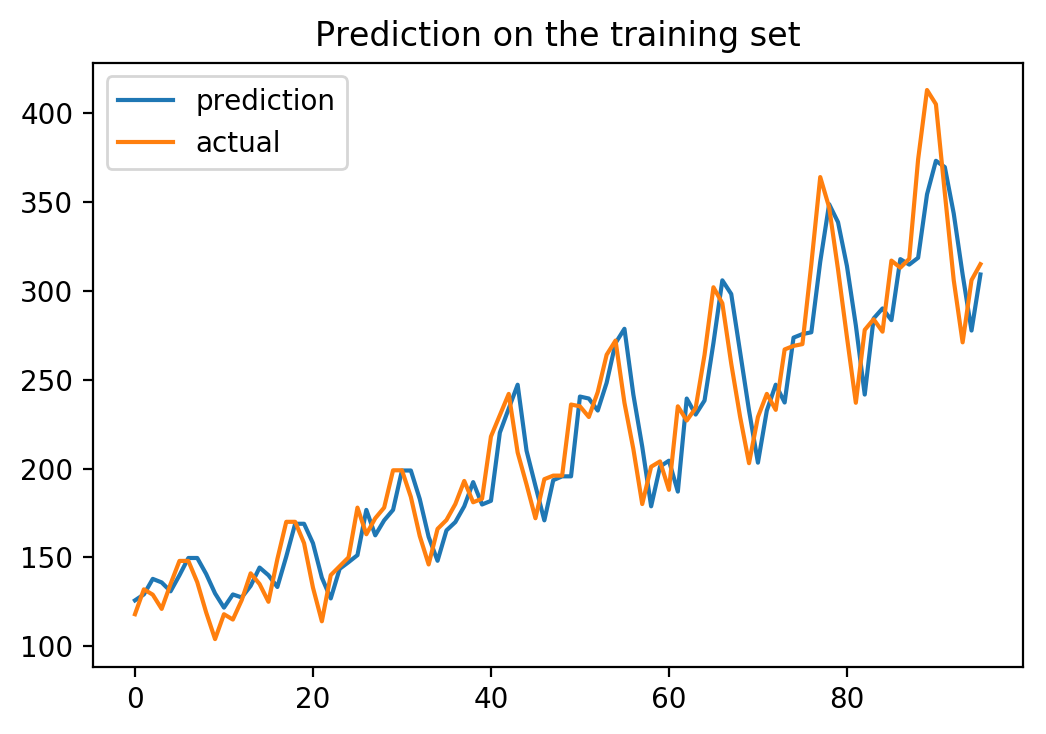

In [10]:
plt.figure(dpi=200)
plt.title('Prediction on the training set')
plt.plot(train_predict, label='prediction')
plt.plot(ssX.inverse_transform(y_train), label='actual')
plt.legend();

In [11]:
train_predict.shape, y_train.shape

((96, 1), (96, 1))

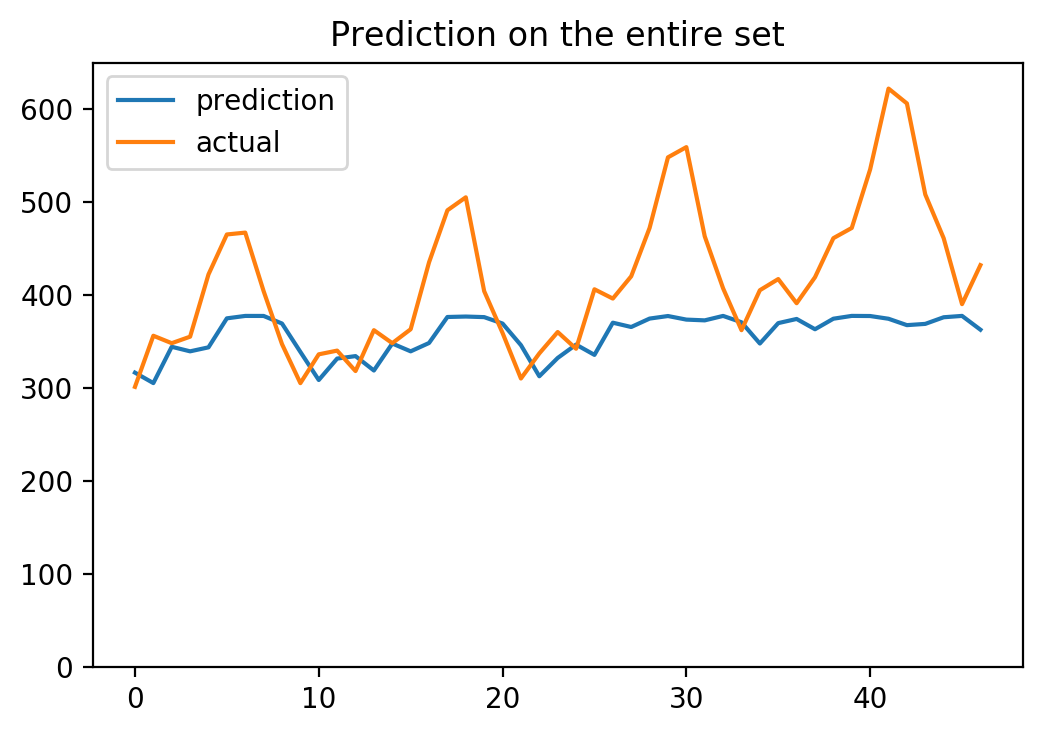

In [12]:
plt.figure(dpi=200)
plt.title('Prediction on the entire set')
plt.plot(test_predict, label='prediction')
plt.plot(ssX.inverse_transform(y_test), label='actual')
plt.ylim(0,650)
plt.legend();

Notice that we really don't do that well on the test set. We do slightly better if we use all the data (including the training data) as that means the LSTM isn't starting "cold"

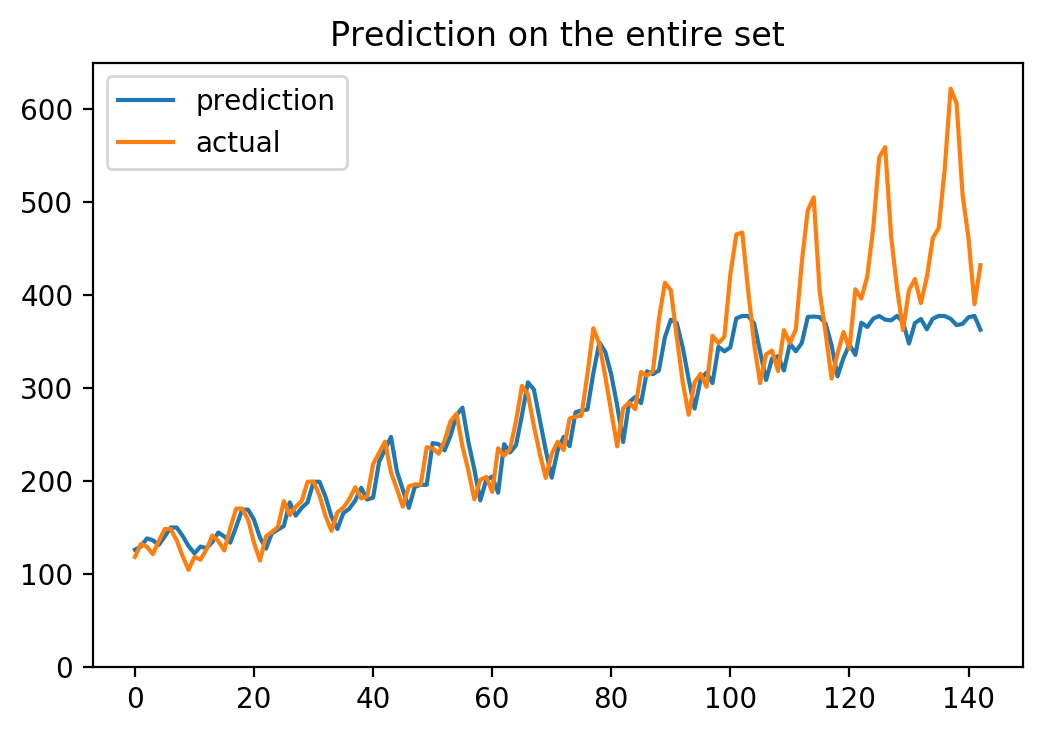

In [13]:
plt.figure(dpi=200)
plt.title('Prediction on the entire set')
plt.plot(all_predict, label='prediction')
plt.plot(ssX.inverse_transform(all_targets), label='actual')
plt.ylim(0,650)
plt.legend();

## Using more time-steps

At the moment, our LSTM uses just the previous time step to make its predictions. Let's use the last `look_back` timesteps

In [14]:
def make_features_and_target(scaled_series, look_back=4):
    """
        input: scaled_series, a Pandas Series that has been standard scaled
        look_back: number of lags to include as features
        
        returns X,y
        X: a (len(scaled_series) - look_back) x look_back array of features
           Row i corresponds to the (scaled) prediction for the original index `i + look_back`
        y: the target. Same number of rows as X. The value in row i is the value of scaled series at index
           `i+look_back`
    """
    df = pd.DataFrame(scaled_series)
    
    shifted_features = [df.shift(+step).values for step in range(1, look_back+1)]
    
    # drop the first "look_back" rows
    X, y = np.concatenate(shifted_features, axis=1)[look_back:], df.values[look_back:]
    return X.reshape(len(X), 1, look_back), y

def get_standard_scaler(orig_series, frac=0.7):
    cutoff = int(frac*(len(orig_series)))
    
    y_train = orig_series.iloc[:cutoff]
    
    ssX = StandardScaler()
    ssX.fit(y_train.values.reshape(-1,1))
    
    return ssX 

look_back=5

ssX = get_standard_scaler(pSeries, 0.7)
cutoff = int(0.7*len(pSeries))

target_scaled = ssX.transform(pSeries.values.reshape(-1,1))
X_scaled, y_scaled = make_features_and_target(target_scaled, look_back=look_back)

X_scaled.shape

(139, 1, 5)

In [15]:
# Do the test/train split:
X_train_scaled, X_test_scaled = X_scaled[:cutoff], X_scaled[cutoff:]
y_train_scaled, y_test_scaled = y_scaled[:cutoff], y_scaled[cutoff:]

In [16]:
model_window = Sequential()
model_window.add(LSTM(4, input_shape=(1, look_back)))
model_window.add(Dense(1))
model_window.compile(loss='mean_squared_error', optimizer='adam')

In [17]:
history = model_window.fit(X_train_scaled, y_train_scaled, epochs=100, batch_size=1, verbose=1,
                       validation_data=(X_test_scaled, y_test_scaled))

Train on 100 samples, validate on 39 samples
Epoch 1/100
100/100 [==============================] - 1s 11ms/step - loss: 1.3292 - val_loss: 8.5267
Epoch 2/100
100/100 [==============================] - 0s 2ms/step - loss: 1.2209 - val_loss: 8.0730
Epoch 3/100
100/100 [==============================] - 0s 2ms/step - loss: 1.1132 - val_loss: 7.3967
Epoch 4/100
100/100 [==============================] - 0s 2ms/step - loss: 0.9743 - val_loss: 6.6525
Epoch 5/100
100/100 [==============================] - 0s 3ms/step - loss: 0.8114 - val_loss: 5.5833
Epoch 6/100
100/100 [==============================] - 0s 3ms/step - loss: 0.6552 - val_loss: 4.6714
Epoch 7/100
100/100 [==============================] - 0s 3ms/step - loss: 0.5365 - val_loss: 3.9516
Epoch 8/100
100/100 [==============================] - 0s 2ms/step - loss: 0.4556 - val_loss: 3.2891
Epoch 9/100
100/100 [==============================] - 0s 3ms/step - loss: 0.4021 - val_loss: 2.7703
Epoch 10/100
100/100 [=======================

Epoch 81/100
100/100 [==============================] - 0s 3ms/step - loss: 0.0844 - val_loss: 0.8783
Epoch 82/100
100/100 [==============================] - 0s 2ms/step - loss: 0.0831 - val_loss: 0.8991
Epoch 83/100
100/100 [==============================] - 0s 2ms/step - loss: 0.0825 - val_loss: 0.8996
Epoch 84/100
100/100 [==============================] - 0s 2ms/step - loss: 0.0814 - val_loss: 0.8804
Epoch 85/100
100/100 [==============================] - 0s 2ms/step - loss: 0.0804 - val_loss: 0.8421
Epoch 86/100
100/100 [==============================] - 0s 2ms/step - loss: 0.0800 - val_loss: 0.8156
Epoch 87/100
100/100 [==============================] - 0s 2ms/step - loss: 0.0799 - val_loss: 0.8475
Epoch 88/100
100/100 [==============================] - 0s 2ms/step - loss: 0.0803 - val_loss: 0.8197
Epoch 89/100
100/100 [==============================] - 0s 2ms/step - loss: 0.0791 - val_loss: 0.8232
Epoch 90/100
100/100 [==============================] - 0s 2ms/step - loss: 0.0772

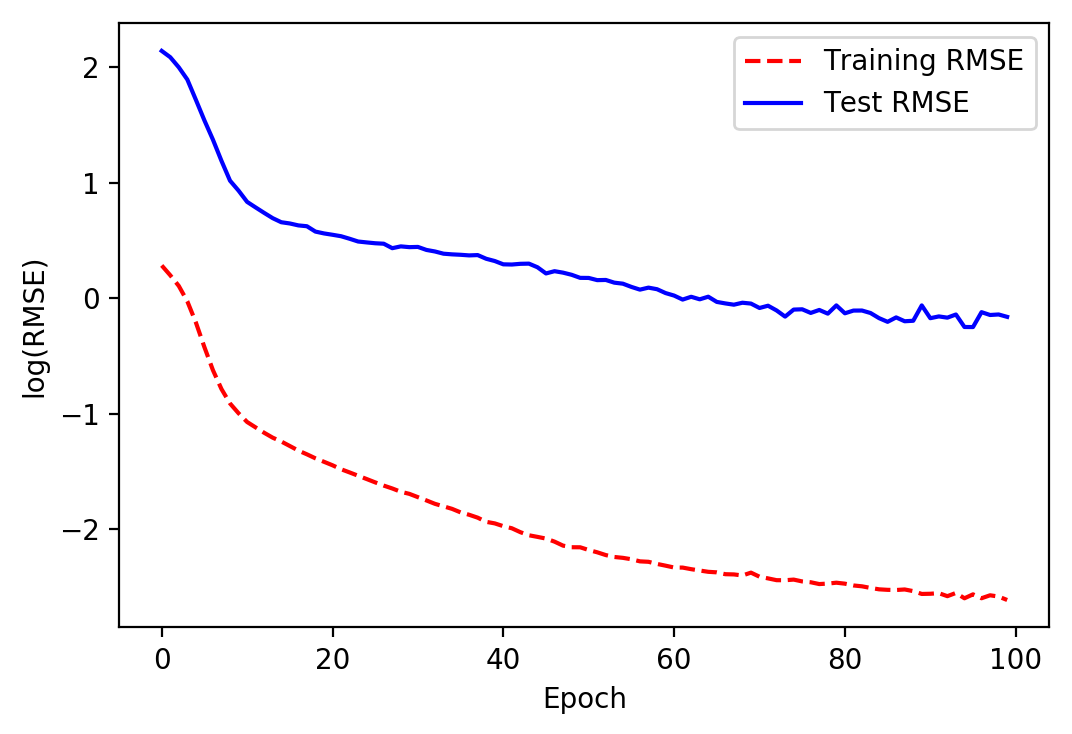

In [18]:
# make a plot of the loss
training_loss = history.history['loss']
test_loss = history.history['val_loss']

epochs = range(len(training_loss))

plt.figure(dpi=200)
plt.plot(epochs, np.log(training_loss), 'r--', label='Training RMSE')
plt.plot(epochs, np.log(test_loss), 'b-', label='Test RMSE')
plt.xlabel('Epoch')
plt.ylabel('log(RMSE)')
plt.legend()

In [19]:
all_features = np.concatenate([X_train_scaled, X_test_scaled])
all_targets  = ssX.inverse_transform(np.concatenate([y_train_scaled, y_test_scaled]))
all_predict = ssX.inverse_transform(model_window.predict(all_features))

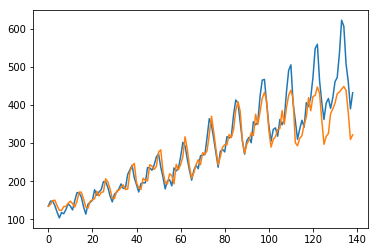

In [20]:
plt.plot(all_targets)
plt.plot(all_predict)

Notice there is a significant amount of overfitting using both last 5 features.